In [2]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:

sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [4]:
x.size()


torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)


In [6]:
qkv = qkv_layer(x)


In [7]:
qkv.shape


torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

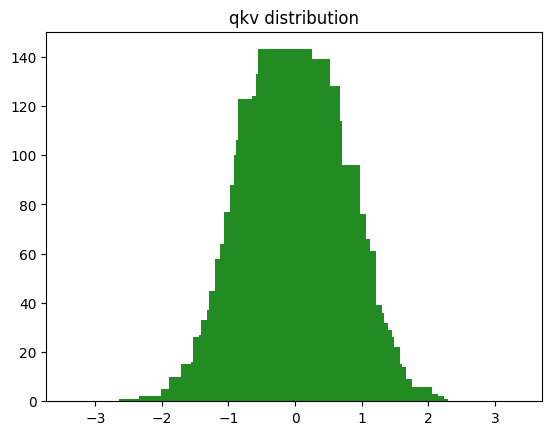

In [8]:

import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [9]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [10]:
qkv.shape


torch.Size([1, 4, 8, 192])

In [11]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [12]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [14]:
import math
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [15]:
k.T.shape


C:\Users\HF\AppData\Local\Temp\ipykernel_9184\3724124494.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [16]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-0.1780,  2.3650],
        [ 0.3990,  0.2473],
        [ 0.6436, -0.0235]])

In [17]:
torch.transpose(y, 1, 0)


tensor([[-0.1780,  2.3650],
        [ 0.3990,  0.2473],
        [ 0.6436, -0.0235]])

In [18]:
k.transpose(-1, -2) == k.transpose(-2, -1)


tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [19]:
k.transpose(-1, -2).shape


torch.Size([1, 8, 64, 4])

In [20]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [21]:
(scaled + mask)[0][0]


tensor([[-0.0637,    -inf,    -inf,    -inf],
        [ 0.5731,  0.0322,    -inf,    -inf],
        [ 0.0465, -0.4584, -0.1729,    -inf],
        [ 0.0159, -0.1977, -0.3363, -0.1855]], grad_fn=<SelectBackward0>)

In [22]:
attention = F.softmax(scaled, dim=-1)


In [23]:

values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])